In [1]:
import os
PATH = r"/home/G/user_students/loggu/project_kla/"

os.chdir(PATH)


In [ ]:
import os
import pandas as pd
from Bio import SeqIO

PATH = r"D:\workspace\PyChramProject\HCC_Kla\"

os.chdir(PATH)


def seq_getter(protein, sequence, label, length, savepath, positive_list=None):
    for i in range(len(sequence)):
        if i >= length and i < len(sequence) - length and sequence[i] == 'K':
            if positive_list is not None:
                if protein + '_' + str(i + 1) not in positive_list:
                    continue
            with open(savepath, 'a') as file:
                file.write('>' + protein + '_' + str(i + 1) + label + '\n')
                file.write(str(sequence[i - length:i + 1 + length]) + '\n')


def human_protein(positive_datapath: str, human_datapath: str, valid_datapath: str, length):
    positive_data = pd.read_excel(positive_datapath, skiprows=13, header=1)  # 读入文件，跳过表头
    positive_list = positive_data.apply(lambda row: f"{row['Protein accession']}_{row['Position']}", axis=1).tolist()
    positive_protein = set(positive_data['Protein accession'].tolist())
    valid_list = valid_datapreprocess(valid_datapath=valid_datapath)
    valid_protein = [item.split('_')[0] for item in valid_list]
    savefloder = PATH + f'{2 * length + 1}AA'
    if not os.path.exists(savefloder):
        os.makedirs(savefloder)
    for record in SeqIO.parse(human_datapath, "fasta"):
        protein_id = record.id.split('|')[1]
        protein_seq = record.seq
        if protein_id in valid_protein:
            seq_getter(protein_id, protein_seq, label='|1|', length=length, savepath=savefloder + 'validtotal.fasta',
                       positive_list=valid_list)
        if protein_id in positive_protein:
            seq_getter(protein_id, protein_seq, label='|1|', length=length, savepath=savefloder + 'positivetotal.fasta',
                       positive_list=positive_list)
        else:
            seq_getter(protein_id, protein_seq, label='|0|', length=length, savepath=savefloder + 'negativetotal.fasta')


def valid_datapreprocess(valid_datapath: str):
    valid_data = pd.read_table(valid_datapath, sep='\t')
    valid_data = valid_data[['Proteins', 'Positions within proteins', 'Protein']]
    valid_data = valid_data[~valid_data['Protein'].str.contains('CON_|REV_', na=False)]
    results = []
    for _, row in valid_data.iterrows():
        # 分割 Proteins 和 Positions 列
        proteins = row["Proteins"].split(";")
        positions = row["Positions within proteins"].split(";")
        # 创建 Protein 和 Position 的映射
        protein_position_mapping = dict(zip(proteins, positions))
        # 根据 "Protein" 列的值获取映射的值
        selected_protein = row["Protein"]
        selected_position = protein_position_mapping.get(selected_protein, "N/A")
        # 保存结果
        results.append(f"{selected_protein}_{selected_position}")
    return results


if __name__ == '__main__':
    positive_datapath = PATH + r"OriginData\42255_2022_710_MOESM3_ESM.xlsx"
    human_datapath = PATH + r"OriginData\uniprotkb_AND_model_organism_9606_2024_09_24.fasta"
    valid_datapath = PATH + r"OriginData\La (K)Sites.txt"
    human_protein(positive_datapath=positive_datapath,
                  human_datapath=human_datapath,
                  valid_datapath=valid_datapath,
                  length=22,
                  )



In [15]:
import pandas as pd
import os
from Bio import SeqIO
PATH = r"/home/G/user_students/loggu/project_kla/"

os.chdir(PATH)

def seq_getter(protein, sequence, length, savepath, positive_list=None):
    templist=[item.split('|')[0] for item in positive_list]
    for i in range(len(sequence)):
        if i >= length and i < len(sequence) - length and sequence[i] == 'K':
            if positive_list is not None:
                if protein + '_' + str(i + 1) in templist:
                    if protein + '_' + str(i + 1)+'|1|' in positive_list:
                        with open(savepath, 'a') as file:
                            file.write('>' + protein + '_' + str(i + 1) + '|1|' + '\n')
                            file.write(str(sequence[i - length:i + 1 + length]) + '\n')
                    elif protein + '_' + str(i + 1)+'|0|' in positive_list:
                        with open(savepath, 'a') as file:
                            file.write('>' + protein + '_' + str(i + 1) + '|0|' + '\n')
                            file.write(str(sequence[i - length:i + 1 + length]) + '\n')

length=22
human_datapath = PATH + r"data/origin_data/uniprotkb_AND_model_organism_9606_2024_09_24.fasta"
protein_datapath = PATH + f"data/{length*2+1}AA/cdhit30/45AA_cdhit30_ori.csv"
protein_data=pd.read_csv(protein_datapath)
protein_position=protein_data['label'].tolist()
protein_position=[item.split('>')[1] for item in protein_position]
# protein_position=[item.split('|')[0] for item in protein_position]
protein_list=set([item.split('_')[0] for item in protein_position])
savefloder = PATH + f'data/{2 * length + 1}AA/cdhit30/'
if not os.path.exists(savefloder):
    os.makedirs(savefloder)
for record in SeqIO.parse(human_datapath, "fasta"):
    protein_id = record.id.split('|')[1]
    protein_seq = record.seq
    if protein_id in protein_list:
        seq_getter(protein_id, protein_seq, length=25, savepath=savefloder + 'autokla_45to51.fasta',
                   positive_list=protein_position)



In [15]:
def AUC_PRC(y_true,y_pred,savepath):
    with open(savepath+"y_true.txt","w") as f:
        f.write(str(y_true))
    with open(savepath+"y_pred.txt","w") as f:
        f.write(str(y_pred))
    # 计算 ROC 曲线
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # 计算 PRC 曲线
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    # average_precision = average_precision_score(y_true, y_pred)
    prc_auc = auc(recall, precision)

    y_pred=np.around(y_pred,0).astype(int)

    # 混淆矩阵
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp+tn)/(tn + fp+ fn + tp)   
    # 灵敏度（召回率）
    sn = tp / (tp + fn)

    # 特异度
    sp = tn / (tn + fp)

    # 马修斯相关系数（MCC）
    mcc = matthews_corrcoef(y_true, y_pred)

    # 绘制 ROC 和 PRC 曲线
    plt.figure(figsize=(12, 6))

    # ROC 曲线
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUROC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # PRC 曲线
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='orange', lw=2, label=f'PRC curve (AUPRC = {prc_auc:.2f})')
    plt.grid(True)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.savefig(savepath+"AUC_PRC.svg",dpi=600)
    
    with open(savepath+"results.txt","w") as f:
        f.write(f'AUROC: {roc_auc:.4f}\n')
        f.write(f'AUPRC: {prc_auc:.4f}\n')        
        f.write(f'Accuracy: {acc:.4f}\n')
        f.write(f'Sensitivity (Recall): {sn:.4f}\n')
        f.write(f'Specificity: {sp:.4f}\n')
        f.write(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}\n')


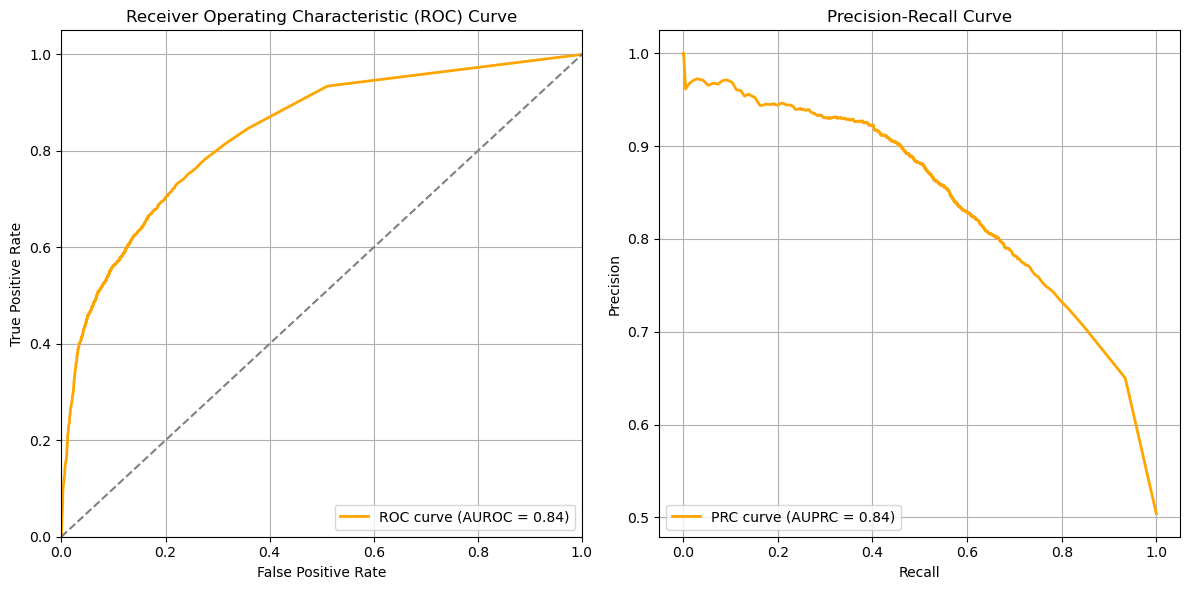

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
import pandas as pd
datapath='/home/G/user_students/loggu/project_kla/Auto-Kla-main/Codes/results.csv'
savepath="/home/G/user_students/loggu/project_kla/Auto-Kla-main/Codes/my_results/"
data=pd.read_csv(datapath)
y_true=[int(item.split('|')[1]) for item in data['Name'].tolist()]
y_pred=[float(item.strip("%"))/100 for item in data['Kla Probability'].tolist()]
AUC_PRC(y_true,y_pred,savepath)

In [2]:
import re
import pandas as pd
res=['batch_size4_lr0.005_roc=0.8657\n',
 'batch_size4_lr0.001_roc=0.8841\n',
 'batch_size4_lr0.0005_roc=0.8756\n',
 'batch_size4_lr0.0001_roc=0.8467\n',
 'batch_size4_lr5e-05_roc=0.8310\n',
 'batch_size4_lr1e-05_roc=0.8134\n',
 'batch_size8_lr0.005_roc=0.8628\n',
 'batch_size8_lr0.001_roc=0.8757\n',
 'batch_size8_lr0.0005_roc=0.8705\n',
 'batch_size8_lr0.0001_roc=0.8210\n',
 'batch_size8_lr5e-05_roc=0.8112\n',
 'batch_size8_lr1e-05_roc=0.8112\n',
 'batch_size16_lr0.005_roc=0.8650\n',
 'batch_size16_lr0.001_roc=0.8819\n',
 'batch_size16_lr0.0005_roc=0.8589\n',
 'batch_size16_lr0.0001_roc=0.8211\n',
 'batch_size16_lr5e-05_roc=0.8188\n',
 'batch_size16_lr1e-05_roc=0.8089\n',
 'batch_size32_lr0.005_roc=0.8831\n',
 'batch_size32_lr0.001_roc=0.8708\n',
 'batch_size32_lr0.0005_roc=0.8551\n',
 'batch_size32_lr0.0001_roc=0.8154\n',
 'batch_size32_lr5e-05_roc=0.8138\n',
 'batch_size32_lr1e-05_roc=0.8126\n',
 'batch_size64_lr0.005_roc=0.8463\n',
 'batch_size64_lr0.001_roc=0.8450\n',
 'batch_size64_lr0.0005_roc=0.8456\n',
 'batch_size64_lr0.0001_roc=0.8184\n',
 'batch_size64_lr5e-05_roc=0.8145\n',
 'batch_size64_lr1e-05_roc=0.8109\n',
 'batch_size128_lr0.005_roc=0.8297\n',
 'batch_size128_lr0.001_roc=0.8486\n',
 'batch_size128_lr0.0005_roc=0.8369\n',
 'batch_size128_lr0.0001_roc=0.8153\n',
 'batch_size128_lr5e-05_roc=0.8142\n',
 'batch_size128_lr1e-05_roc=0.8105\n']
data=res
batch_sizes = []
lrs = []
rocs = []
for entry in data:
    match = re.match(r'batch_size(\d+)_lr([0-9.e-]+)_roc=([0-9.]+)', entry.strip())
    if match:
        batch_sizes.append(int(match.group(1)))
        lrs.append(float(match.group(2)))
        rocs.append(float(match.group(3)))

# Create a pandas DataFrame
df = pd.DataFrame({
    'batch_size': batch_sizes,
    'learning_rate': lrs,
    'roc': rocs
})

In [4]:
df

,batch_size,learning_rate,roc
0,4,0.00500,0.8657
1,4,0.00100,0.8841
2,4,0.00050,0.8756
3,4,0.00010,0.8467
4,4,0.00005,0.8310
5,4,0.00001,0.8134
6,8,0.00500,0.8628
7,8,0.00100,0.8757
8,8,0.00050,0.8705
9,8,0.00010,0.8210


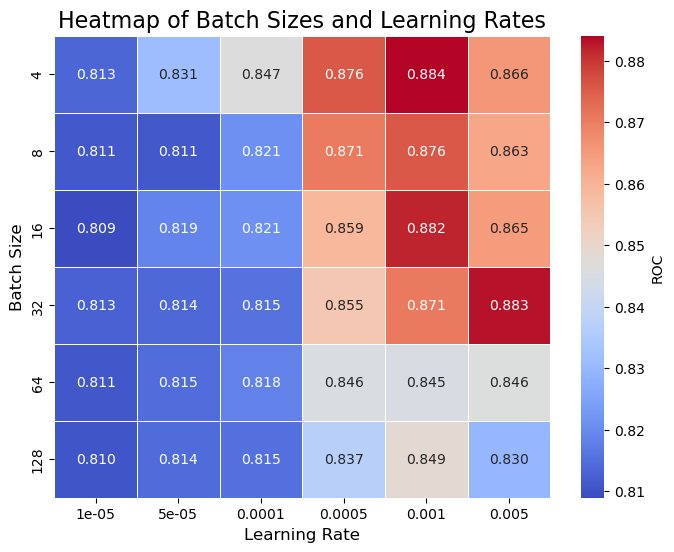

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
heatmap_data = df.pivot(index="batch_size", columns="learning_rate", values="roc")

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5, cbar_kws={'label': 'ROC'})

# Title and labels
plt.title('Heatmap of Batch Sizes and Learning Rates', fontsize=16)
plt.xlabel('Learning Rate', fontsize=12)
plt.ylabel('Batch Size', fontsize=12)
plt.show()